# Facial Landmark Detection Using Convolutional Neural Networks

### Project Overview

This project utilizes Convolutional Neural Networks (CNNs) to detect facial landmarks in images. By training a model on a dataset of facial images, the goal is to accurately predict the positions of key facial features such as eyes, nose, and mouth. The model processes input images, extracts relevant features through multiple convolutional layers, and outputs the coordinates of the landmarks. This work can be applied in various fields, including facial recognition, emotion analysis, and augmented reality.

Dataset: https://www.kaggle.com/c/facial-keypoints-detection/data


In [196]:
# Imports
import os
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [197]:
# Path to data

F_TRAIN = Path("training.csv")
F_TEST = Path("test.csv")


In [198]:
# Function to load data

def load_data(test: bool = False) -> tuple[np.ndarray, np.ndarray | None]:
    """
    Load image data and preprocess it.
    
    Parameters:
        test (bool): If True, load test data without labels.
        
    Returns:
        tuple: (X, y) where X is the array of images and y is the array of labels (or None for test data).
    """
    fname = F_TEST if test else F_TRAIN
    df = pd.read_csv(fname)

    # Load and preprocess image data
    df['Image'] = df['Image'].apply(lambda im: np.fromiter(
        map(float, im.split()), dtype=np.float32))
    df = df.dropna()

    # Convert to numpy array and normalize images
    X = np.array(df['Image'].to_list()) / 255.0  # Normalize directly
    X = X.reshape(-1, 96, 96, 1)  # Reshape for CNN

    if not test:
        y = df.iloc[:, :-1].to_numpy()  # Get labels
        y = (y - 48) / 48.0  # Scale labels

        # Shuffle the data
        X, y = shuffle(X, y, random_state=42)
        return X.astype(np.float32), y.astype(np.float32)

    return X.astype(np.float32), None
 
    

In [199]:
# Loading train data

X, y = load_data()
print(f"X.shape == {X.shape}")
print(f"y.shape == {y.shape}; y.min == {y.min():.3f}; y.max == {y.max():.3f}")


X.shape == (2140, 96, 96, 1)
y.shape == (2140, 30); y.min == -0.920; y.max == 0.996


In [200]:
# Loading test data
X_test, _ = load_data(test=True)
print(f"X_test.shape == {X_test.shape}")

X_test.shape == (1783, 96, 96, 1)


In [201]:
# Function to plot data

def plot_data(img: np.ndarray, landmarks=None, axis=None):
    axis.imshow(np.squeeze(img), cmap="gray")
    axis.scatter(landmarks[0::2] * 48 + 48 , landmarks[1::2] * 48 + 48, marker='.', c='red', s=34)



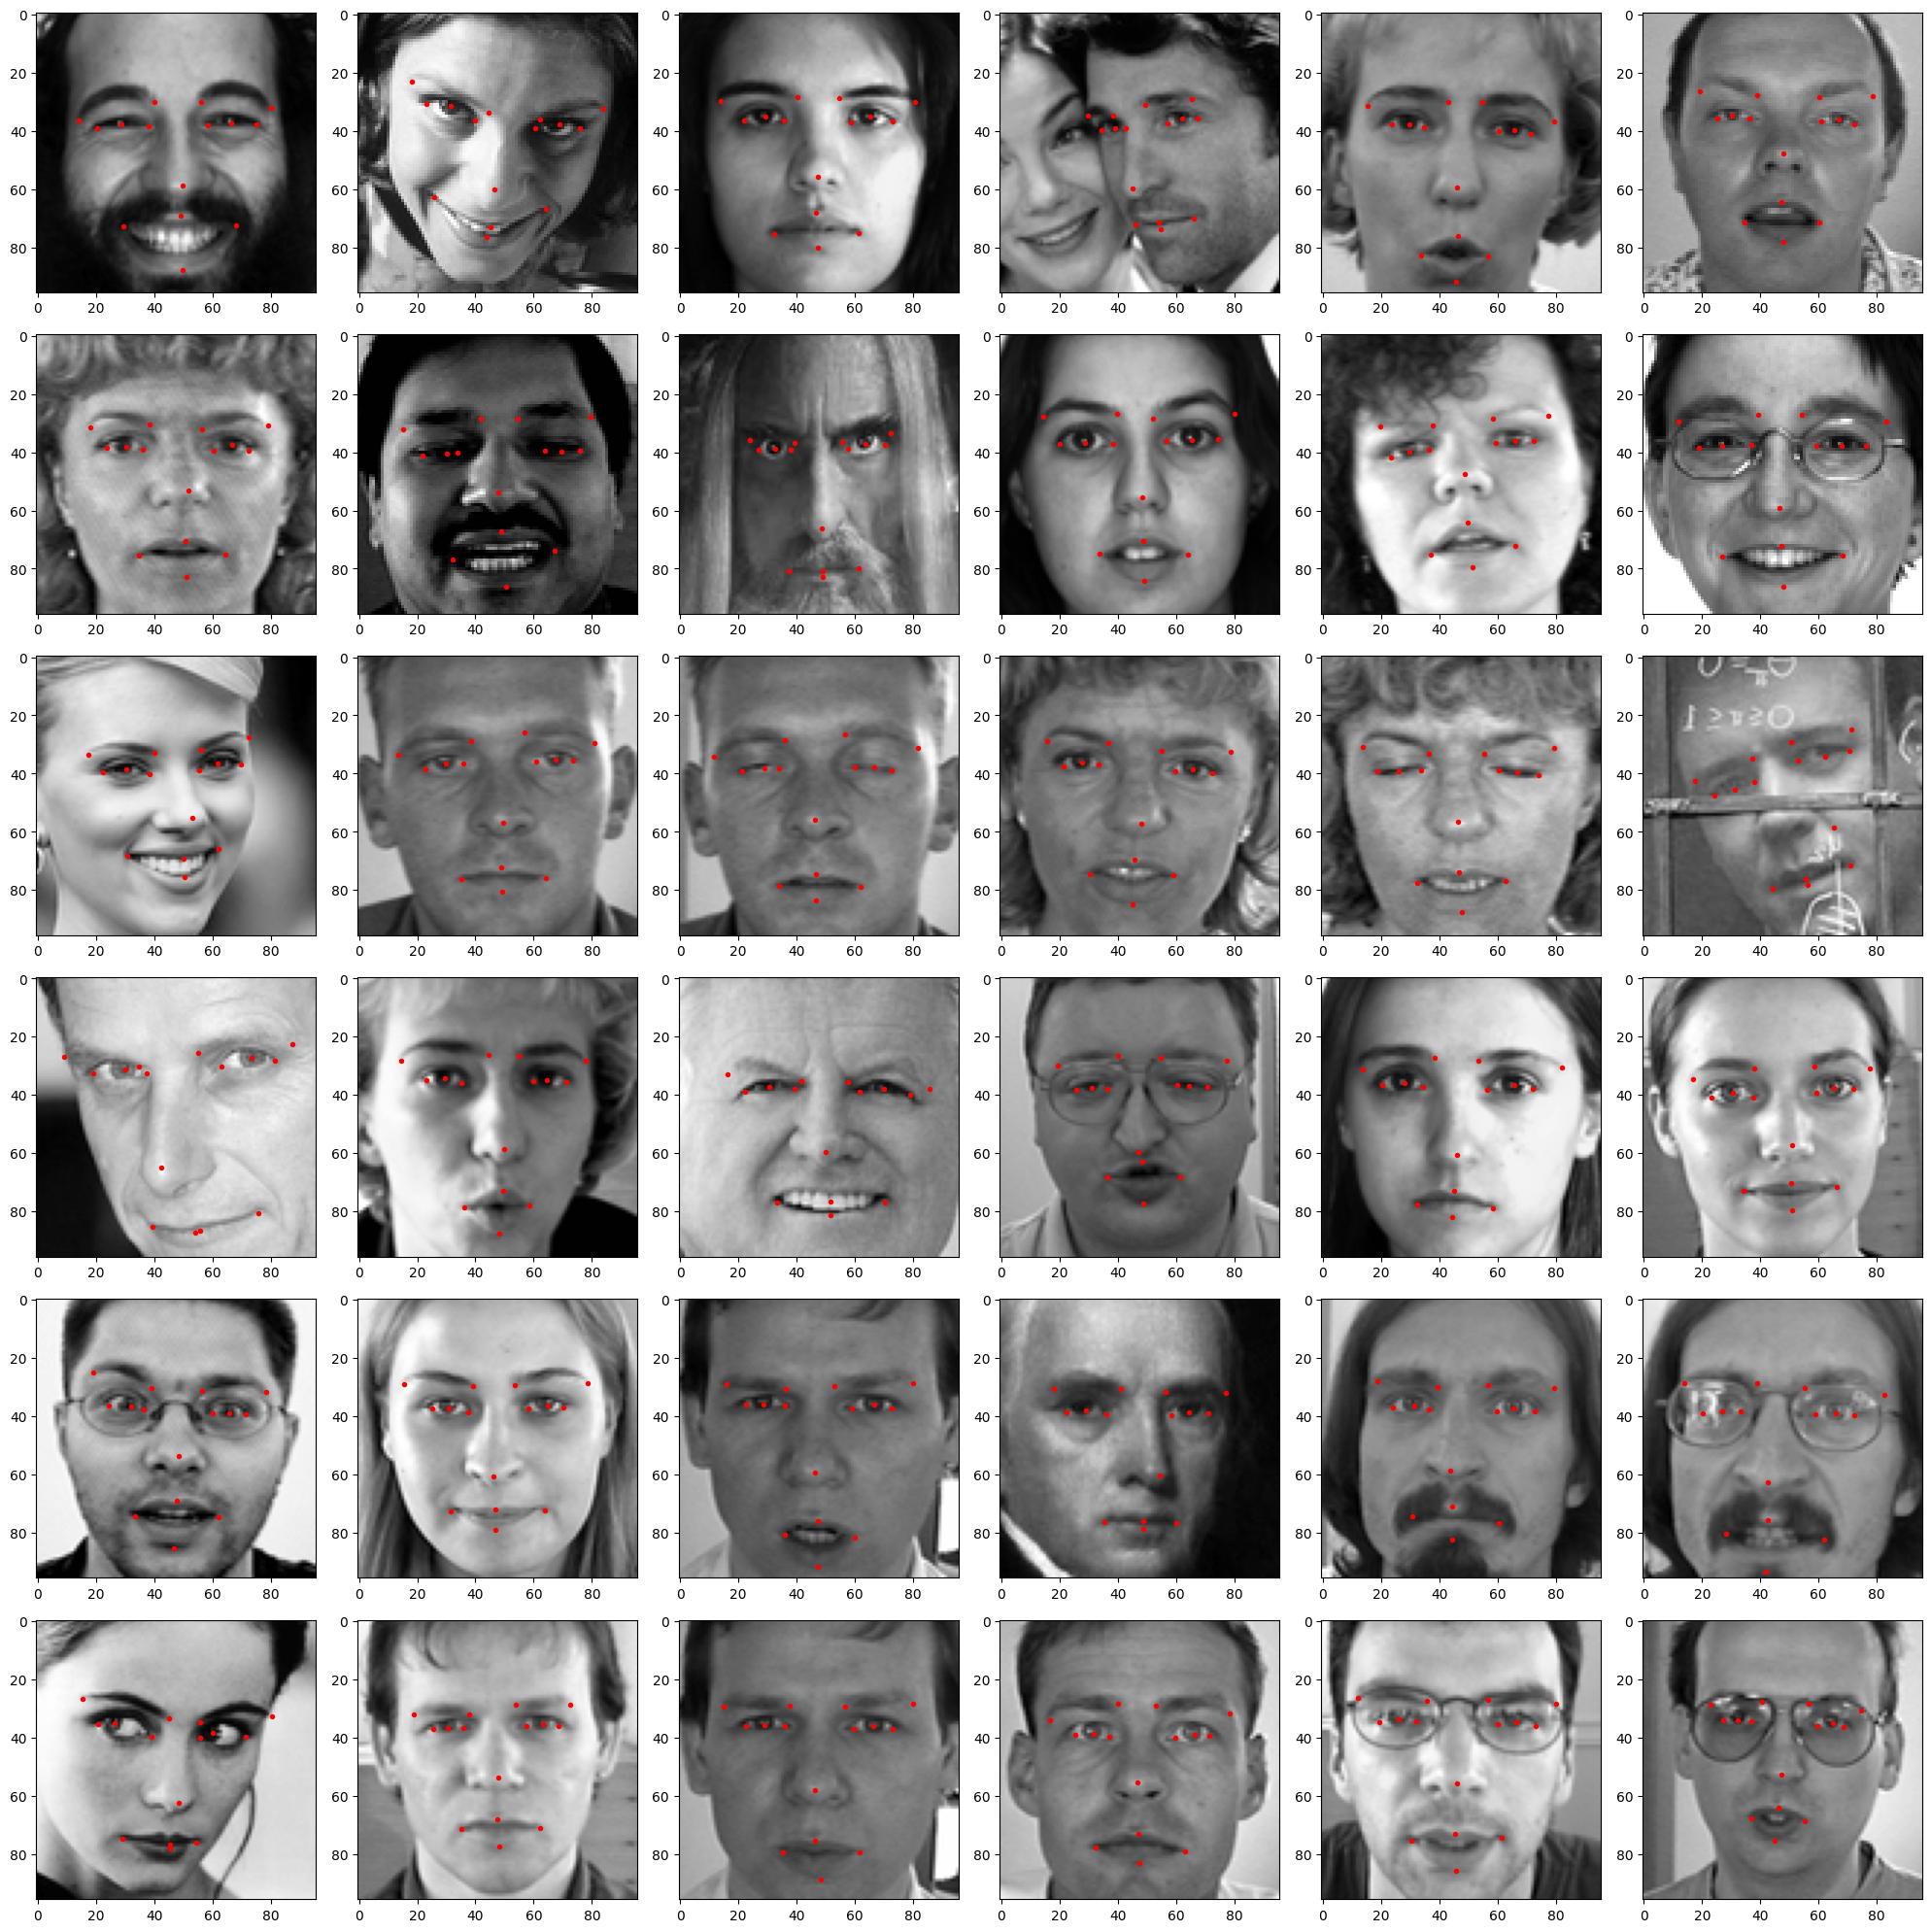

In [202]:
# Plot

fig, axes = plt.subplots(6, 6, figsize=(20,20))
for i, ax in enumerate(axes.flatten()):
    plot_data(X[i], y[i], ax)

plt.tight_layout()
plt.show()

In [233]:
# Model
model = Sequential([
    Input(shape=(96, 96, 1)),
    Conv2D(32, (3, 3), activation='relu',
           padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation='relu',
           padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (2, 2), activation='relu',
           padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(30, activation='linear')  
])

In [234]:
# Model summary

model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_102 (Conv2D)             │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_102               │ (None, 48, 48, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 48, 48, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_103               │ (None, 24, 24, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 24, 24, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_104               │ (None, 12, 12, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 200)            │       102,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,611,366 (36.66 MB)

 Trainable params: 9,611,366 (36.66 MB)

 Non-trainable params: 0 (0.00 B)

In [235]:


optim = Adam(learning_rate=0.001)
model.compile(optimizer=optim, loss='mse', metrics=['accuracy'])
hist = model.fit(X, y, epochs=96, validation_split=0.2)



Epoch 1/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.3028 - loss: 0.0467 - val_accuracy: 0.6963 - val_loss: 0.0046
Epoch 2/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step - accuracy: 0.6446 - loss: 0.0075 - val_accuracy: 0.6963 - val_loss: 0.0043
Epoch 3/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 255ms/step - accuracy: 0.6822 - loss: 0.0059 - val_accuracy: 0.6963 - val_loss: 0.0040
Epoch 4/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.7048 - loss: 0.0052 - val_accuracy: 0.6986 - val_loss: 0.0041
Epoch 5/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 259ms/step - accuracy: 0.6754 - loss: 0.0045 - val_accuracy: 0.6846 - val_loss: 0.0037
Epoch 6/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 247ms/step - accuracy: 0.7022 - loss: 0.0038 - val_accuracy: 0.7009 - val_loss: 0.0027
Epoch 7/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 227ms/step - accuracy: 0.7058 - loss: 0.0032 - val_accuracy: 0.7056 - val_loss: 0.0024
Epoch 8/96
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 229ms/step - accuracy: 0.7094 - loss: 0.0028 - val_accu

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step


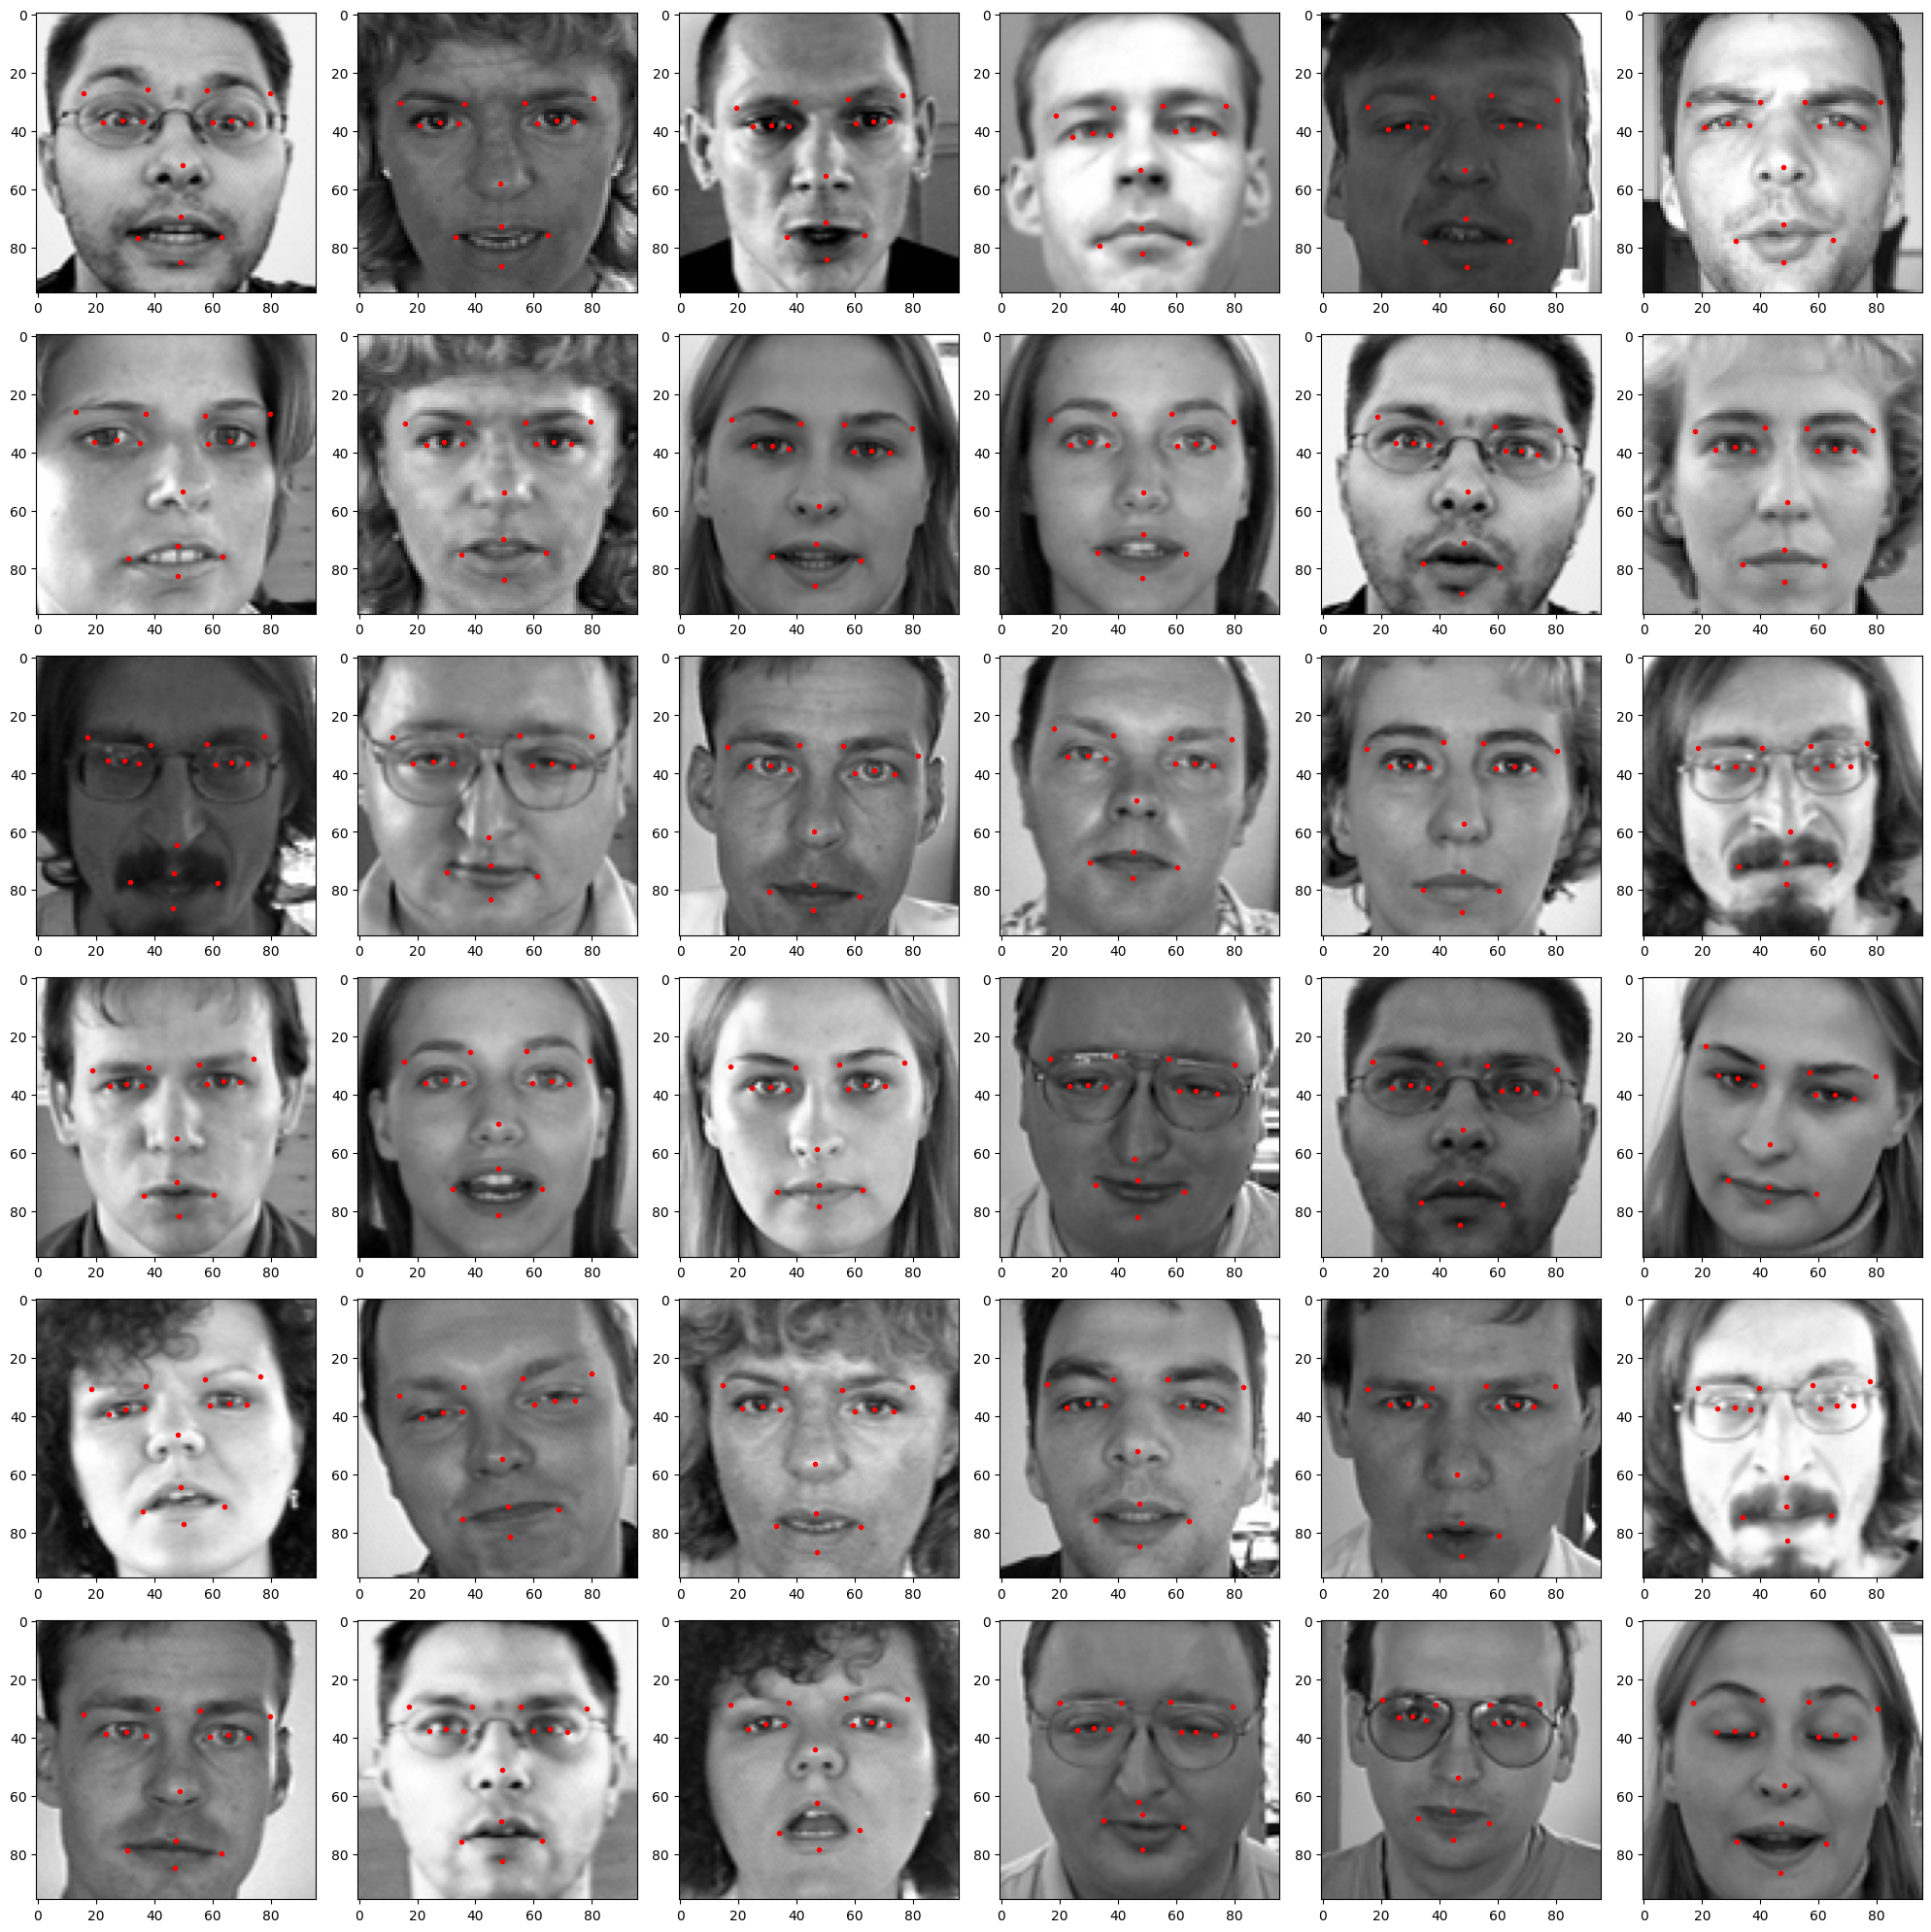

In [228]:
# Results examples

y_test = model.predict(X_test)
fig, axes = plt.subplots(6, 6, figsize=(20,20))
for i, ax in enumerate(axes.flatten()):
    plot_data(X_test[i], y_test[i], ax)
plt.tight_layout()
plt.show()






dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


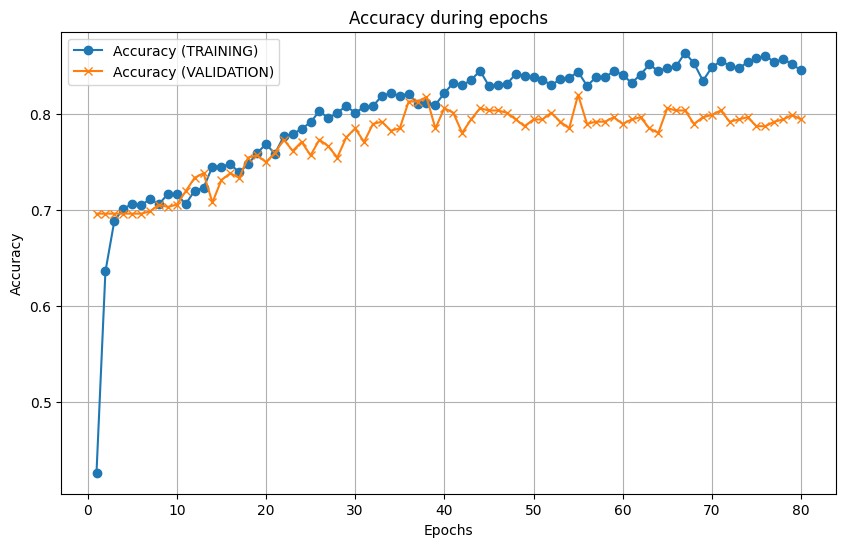

In [229]:
print(hist.history.keys())

accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, label="Accuracy (TRAINING)", marker='o')
plt.plot(epochs, val_accuracy, label="Accuracy (VALIDATION)", marker='x')
plt.title("Accuracy during epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.grid(True)
plt.legend()
plt.show()

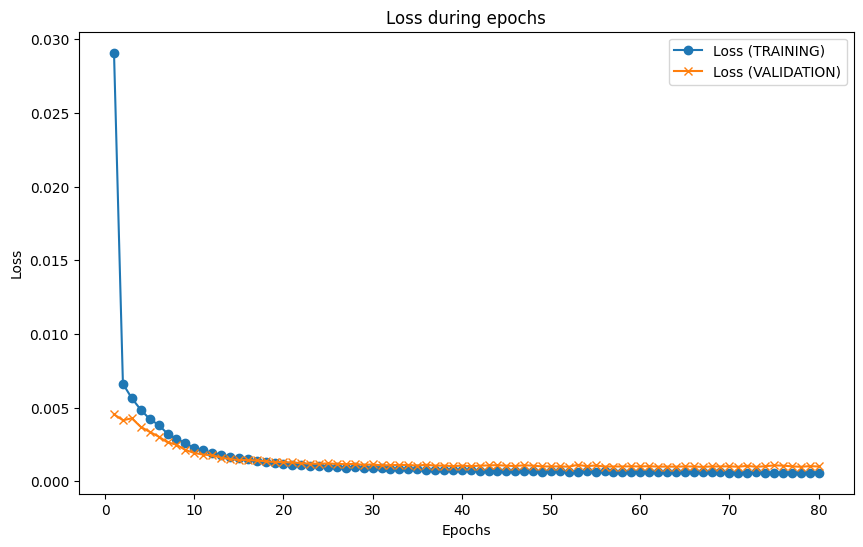

In [230]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label="Loss (TRAINING)", marker='o')
plt.plot(epochs, val_loss, label="Loss (VALIDATION)", marker='x')
plt.title("Loss during epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")


plt.legend()
plt.show()

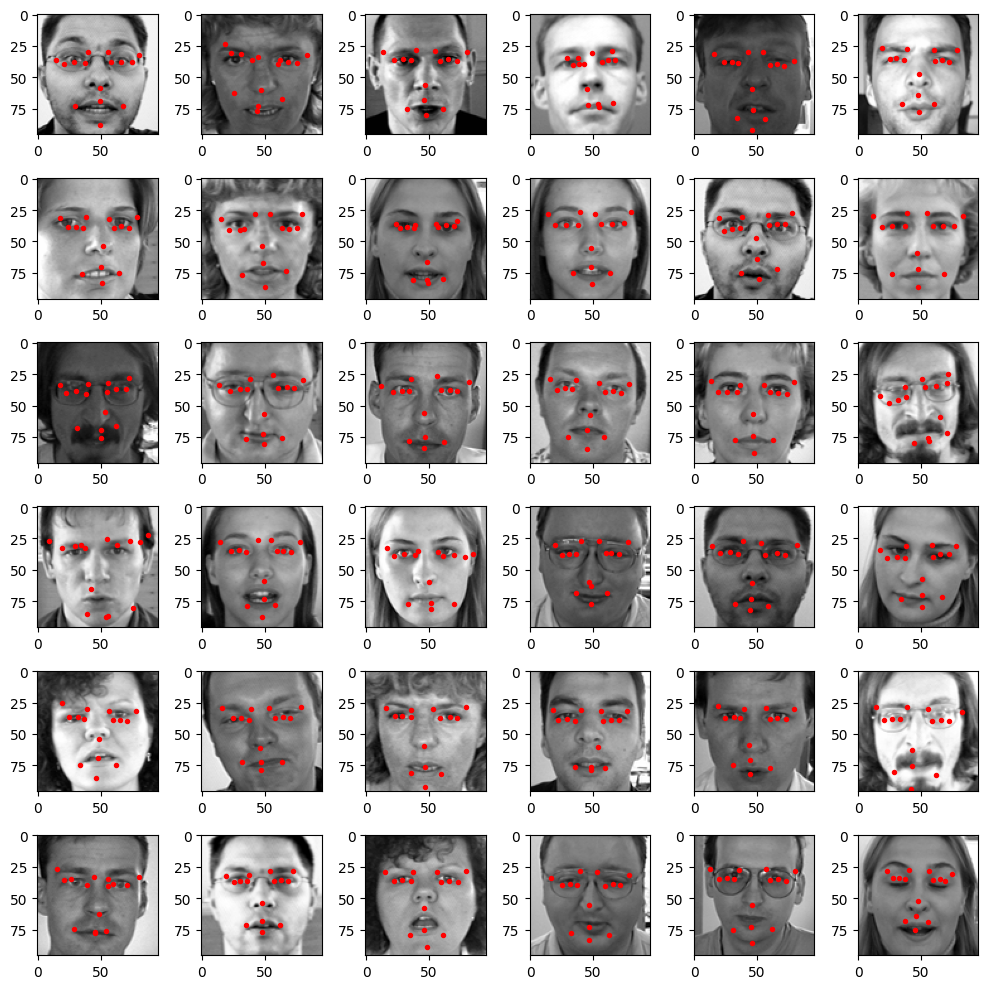

In [231]:
# Errors examples

fig, axes = plt.subplots(6, 6, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    # Verifica se os landmarks previstos estão diferentes dos reais
    # Supondo que y_true contém os valores corretos
    if not np.array_equal(X_test[i], y[i]):
        # Plota a imagem e passa um array vazio para landmarks
        plot_data(X_test[i], y[i], ax)
plt.tight_layout()
plt.show()

In [232]:
model.save('mymodel.keras')